In [ ]:
# ========================================
# SECTION 1: IMPORTS & SETUP
# ========================================
import os
import pandas as pd
import numpy as np
os.environ['OPENCV_CORE_PARALLEL_BACKEND'] = 'TBB'
from pathlib import Path
import shutil
import random
import uuid
import hashlib
import itertools
from typing import Tuple, List
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image
import albumentations as A

# sklearn for splitting
from sklearn.model_selection import StratifiedGroupKFold

# Try to import imagehash for duplicate detection
try:
    import imagehash
    IMAGEHASH_AVAILABLE = True
except ImportError:
    IMAGEHASH_AVAILABLE = False
    print("⚠️  WARNING: imagehash library not installed!")
    print("   Duplicate detection will use filename-based hashing only.")
    print("   Install with: pip install imagehash")
    print()

# Verify imports
print("✓ All imports successful!")
print(f"✓ OpenCV version: {cv2.__version__}")
print(f"✓ Albumentations available")
if IMAGEHASH_AVAILABLE:
    print(f"✓ imagehash available (perceptual hashing enabled)")

# Set seeds for reproducibility
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
print(f"✓ Random seed set to {GLOBAL_SEED}")

# ========================================
# GOOGLE COLAB SETUP
# ========================================
# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("\n" + "="*60)
    print("🔗 GOOGLE COLAB DETECTED")
    print("="*60)
    
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✓ Google Drive mounted at /content/drive")
    
    # Set Colab-specific paths
    COLAB_DRIVE_ROOT = Path("/content/drive/MyDrive")
    USE_DRIVE = True
    print(f"✓ Will save output to Google Drive")
    print("="*60 + "\n")
    
except ImportError:
    IN_COLAB = False
    USE_DRIVE = False
    print("\n✓ Running locally (not in Colab)\n")

# ========================================
# SECTION 2: CONFIGURATION - ADAPTIVE AUGMENTATION
# ========================================

# --- PATHS ---
if IN_COLAB and USE_DRIVE:
    # Google Colab paths (saves to Google Drive)
    ROOT = Path("/content/drive/MyDrive/CSE465/Raw_Dataset")  # Upload your Raw_Dataset here
    OUT_ROOT = Path("/content/drive/MyDrive/CSE465/Dataset_split")  # Output will save here
    METADATA_DIR = Path("/content/drive/MyDrive/CSE465/metadata")
    print("📂 Using Google Drive paths:")
    print(f"   Input:  {ROOT}")
    print(f"   Output: {OUT_ROOT}")
else:
    # Local paths
    ROOT = Path("/Users/alimran/Desktop/CSE465/Raw_Dataset")  # Your raw dataset location
    OUT_ROOT = Path("Dataset_split")  # Where processed dataset will be saved
    METADATA_DIR = Path("metadata")
    print("📂 Using local paths:")
    print(f"   Input:  {ROOT}")
    print(f"   Output: {OUT_ROOT}")

OUT_CSV = METADATA_DIR / "splits.csv"

# Create metadata directory
METADATA_DIR.mkdir(parents=True, exist_ok=True)

# --- SPLIT RATIOS (for original images only) ---
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# --- AUGMENTATION CONFIG (ADAPTIVE) ---
TRAIN_TARGET_PER_CLASS = 1000    # Target training images per class (balanced)
IMG_SIZE = 224                   # Resize for images
AUG_QUALITY = 95                 # JPEG quality for augmented images

# --- NORMALIZATION CONFIG ---
APPLY_NORMALIZATION = False     # ⚠️ DISABLED: No preprocessing normalization (models will handle ImageNet norm)
# NORMALIZATION_CLAHE_CLIP = 1.5  # Not used (normalization disabled)
BACKGROUND_COLOR = (0, 0, 0)    # Black background for transparent images

# --- DUPLICATE DETECTION ---
PHASH_SIZE = 16                 # pHash size for duplicate detection

# --- FILE EXTENSIONS ---
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# Display config
print("="*60)
print("CONFIGURATION - ADAPTIVE AUGMENTATION STRATEGY")
print("="*60)
print(f"Raw Dataset Root:     {ROOT}")
print(f"Output Dataset Root:  {OUT_ROOT}")
if IN_COLAB and USE_DRIVE:
    print(f"💾 Output will be saved to Google Drive")
print(f"Split Ratios:         Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}")
print(f"  → Applied to ORIGINAL images only")
print(f"  → Val/Test will be PURE (no augmentation)")
print(f"Training Target:      {TRAIN_TARGET_PER_CLASS} per class (balanced via augmentation)")
print(f"Background Color:     {BACKGROUND_COLOR}")
print(f"\n🔄 PREPROCESSING APPROACH:")
print(f"  ✓ Handle transparency → Black background")
print(f"  ✓ Resize to {IMG_SIZE}×{IMG_SIZE}")
print(f"  ✓ Save as clean RGB images")
print(f"  ✗ NO normalization applied (models will handle ImageNet normalization)")
print(f"\n🔄 ADAPTIVE AUGMENTATION FEATURES:")
print(f"  1. Dynamic max_aug_per_source based on imbalance ratio")
print(f"  2. Stronger augmentation pipelines for minority classes")
print(f"  3. Three augmentation levels: MILD, MODERATE, STRONG")
print(f"Image Size:           {IMG_SIZE}x{IMG_SIZE}")
print("="*60 + "\n")

# Verify raw dataset exists
if not ROOT.exists():
    error_msg = f"Raw dataset not found at: {ROOT}"
    if IN_COLAB:
        error_msg += "\n\n📌 COLAB SETUP INSTRUCTIONS:"
        error_msg += f"\n   1. Upload your Raw_Dataset folder to Google Drive"
        error_msg += f"\n   2. Place it at: /MyDrive/CSE465/Raw_Dataset/"
        error_msg += f"\n   3. Folder structure should be:"
        error_msg += f"\n      /MyDrive/CSE465/Raw_Dataset/"
        error_msg += f"\n        ├── eggplant_bacterial/"
        error_msg += f"\n        ├── eggplant_fungal/"
        error_msg += f"\n        ├── potato_bacterial/"
        error_msg += f"\n        └── ..."
    raise FileNotFoundError(error_msg)
print(f"✓ Raw dataset found at {ROOT}")

# ========================================
# SECTION 2.5: IMAGE HANDLING FUNCTIONS
# ========================================

def read_image_with_transparency(path: Path, bg_color=(0, 0, 0)):
    """
    Properly handle images with transparent backgrounds.
    Converts transparency to consistent background color.
    """
    try:
        pil_img = Image.open(path)
        
        if pil_img.mode in ('RGBA', 'LA', 'P'):
            if pil_img.mode == 'P':
                pil_img = pil_img.convert('RGBA')
            
            background = Image.new('RGB', pil_img.size, (bg_color[2], bg_color[1], bg_color[0]))
            
            if pil_img.mode in ('RGBA', 'LA'):
                background.paste(pil_img, mask=pil_img.split()[-1])
            else:
                background.paste(pil_img)
            
            img_bgr = cv2.cvtColor(np.array(background), cv2.COLOR_RGB2BGR)
            return img_bgr
        else:
            img = cv2.imread(str(path), cv2.IMREAD_COLOR)
            if img is None:
                raise RuntimeError(f"Failed to read image: {path}")
            return img
            
    except Exception as e:
        print(f"⚠ Warning loading {path.name}: {e}, using fallback")
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            raise RuntimeError(f"Failed to read image: {path}")
        return img


def resize_image(img, target_size=(224, 224)):
    """
    Simple resize without normalization.
    Models will apply their own normalization (e.g., ImageNet stats).
    """
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)
    return img


print("\n✓ Image handling functions loaded")

# ========================================
# SECTION 2.7: ADAPTIVE AUGMENTATION FUNCTIONS
# ========================================

def get_max_aug_per_source(original_count: int, target: int) -> int:
    """
    Calculate dynamic max augmentations per source based on imbalance ratio.
    
    Args:
        original_count: Number of original images for this class
        target: Target number of images after augmentation
    
    Returns:
        Maximum augmentations to create from a single source image
    """
    if original_count == 0:
        return 8
    
    imbalance_ratio = target / original_count
    
    if imbalance_ratio > 5.0:
        return 8
    elif imbalance_ratio > 3.0:
        return 6
    elif imbalance_ratio > 2.0:
        return 5
    else:
        return 4


def get_augmentation_pipeline(class_name: str, original_count: int, target: int):
    """
    Create augmentation pipeline based on class imbalance ratio.
    
    Args:
        class_name: Name of the class
        original_count: Number of original images
        target: Target number of images
    
    Returns:
        Albumentations pipeline (MILD, MODERATE, or STRONG)
    """
    if original_count == 0:
        imbalance_ratio = float('inf')
    else:
        imbalance_ratio = target / original_count
    
    # Determine augmentation strength
    if imbalance_ratio > 2.0:
        # STRONG augmentation for severe minorities (>2x imbalance)
        pipeline = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),  # Increased from 0.12
            A.ShiftScaleRotate(
                shift_limit=0.03,      # Increased from 0.02
                scale_limit=0.15,      # Increased from 0.1
                rotate_limit=20,       # Increased from 10
                border_mode=cv2.BORDER_CONSTANT,
                value=BACKGROUND_COLOR[0],
                p=0.7                  # Increased from 0.6
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.25, # Increased from 0.15
                contrast_limit=0.25,   # Increased from 0.15
                p=0.5                  # Increased from 0.4
            ),
            A.HueSaturationValue(
                hue_shift_limit=12,    # Increased from 8
                sat_shift_limit=20,    # Increased from 15
                val_shift_limit=20,    # Increased from 15
                p=0.5                  # Increased from 0.4
            ),
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=1.0),
                A.MedianBlur(blur_limit=5, p=1.0),
            ], p=0.2),                 # Increased from 0.15
            A.GaussNoise(var_limit=(5.0, 15.0), p=0.3),  # Increased from 0.2
            A.CoarseDropout(
                max_holes=3,
                max_height=20,
                max_width=20,
                fill_value=BACKGROUND_COLOR[0],
                p=0.2
            ),  # NEW
            A.RandomGamma(gamma_limit=(80, 120), p=0.2),  # NEW
        ])
        strength = "STRONG"
        
    elif imbalance_ratio > 1.5:
        # MODERATE augmentation for moderate minorities (1.5-2x imbalance)
        pipeline = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),  # Increased from 0.12
            A.ShiftScaleRotate(
                shift_limit=0.025,
                scale_limit=0.12,
                rotate_limit=15,
                border_mode=cv2.BORDER_CONSTANT,
                value=BACKGROUND_COLOR[0],
                p=0.65
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.2,
                contrast_limit=0.2,
                p=0.45
            ),
            A.HueSaturationValue(
                hue_shift_limit=10,
                sat_shift_limit=17,
                val_shift_limit=17,
                p=0.45
            ),
            A.GaussianBlur(blur_limit=(3, 5), p=0.18),
            A.GaussNoise(var_limit=(5.0, 13.0), p=0.25),
            A.CoarseDropout(
                max_holes=2,
                max_height=15,
                max_width=15,
                fill_value=BACKGROUND_COLOR[0],
                p=0.15
            ),
        ])
        strength = "MODERATE"
        
    else:
        # MILD augmentation for well-represented classes (<1.5x imbalance)
        pipeline = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.12),
            A.ShiftScaleRotate(
                shift_limit=0.02,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=cv2.BORDER_CONSTANT,
                value=BACKGROUND_COLOR[0],
                p=0.6
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.15,
                contrast_limit=0.15,
                p=0.4
            ),
            A.HueSaturationValue(
                hue_shift_limit=8,
                sat_shift_limit=15,
                val_shift_limit=15,
                p=0.4
            ),
            A.GaussianBlur(blur_limit=(3, 5), p=0.15),
            A.GaussNoise(var_limit=(5.0, 12.0), p=0.2),
        ])
        strength = "MILD"
    
    return pipeline, strength, imbalance_ratio


print("\n✓ Adaptive augmentation functions loaded")

# ========================================
# SECTION 3: BUILD DATAFRAME & DETECT DUPLICATES
# ========================================

def build_df_from_joint_dirs(root: Path) -> pd.DataFrame:
    """
    Expects folder structure:
        root/
          Guava_Anthracnose/
          Guava_Healthy/
          Mango_Anthracnose/
          Mango_Healthy/
          Papaya_Anthracnose/
          Papaya_Healthy/
    """
    rows = []
    for joint_dir in sorted(d.name for d in root.iterdir() if d.is_dir()):
        j = joint_dir.strip()
        if "_" not in j:
            print(f"⚠ Skipping folder (no underscore): {j}")
            continue

        species, health = j.split("_", 1)
        folder_path = root / joint_dir

        for img_path in folder_path.rglob("*"):
            if img_path.suffix.lower() in IMG_EXTS:
                rows.append({
                    "path": str(img_path),
                    "species": species,
                    "health": health,
                    "joint_label": j
                })

    return pd.DataFrame(rows)

# Build dataframe
print("\n" + "="*60)
print("Building dataset dataframe...")
df = build_df_from_joint_dirs(ROOT)

# Normalize labels
df["species"] = df["species"].str.strip().str.lower()
df["health"] = df["health"].str.strip().str.lower()
df["joint_label"] = df["species"].str.title() + "_" + df["health"].str.title()

print(f"✓ Found {len(df)} images across {df['joint_label'].nunique()} classes\n")

# Display class distribution
print("Class Distribution (Original Images):")
print("="*60)
class_counts = df["joint_label"].value_counts().sort_index()
for cls, count in class_counts.items():
    print(f"  {cls:25s}: {count:4d} images")
print("="*60 + "\n")

# --- DUPLICATE DETECTION WITH IMPROVED PHASH ---
def phash_or_fallback(path: str, hash_size: int = 16) -> str:
    """
    Generate pHash for image with improved error handling.
    Falls back to filename hash only for corrupted images.
    """
    if not IMAGEHASH_AVAILABLE:
        # Use filename hash if library not available
        p = Path(path)
        key = (p.parent.name + "/" + p.stem).lower()
        return "fname_" + hashlib.md5(key.encode("utf-8")).hexdigest()[:16]
    
    try:
        with Image.open(path) as im:
            im = im.convert("RGB")
            h = imagehash.phash(im, hash_size=hash_size)
        return f"phash_{str(h)}"
    
    except FileNotFoundError:
        print(f"⚠ File not found: {path}")
        raise
    
    except (OSError, IOError) as e:
        # Corrupted or unreadable image - use filename fallback
        print(f"⚠ Error reading {Path(path).name}: {e} - using filename hash")
        p = Path(path)
        key = (p.parent.name + "/" + p.stem).lower()
        return "fname_" + hashlib.md5(key.encode("utf-8")).hexdigest()[:16]
    
    except Exception as e:
        print(f"⚠ Unexpected error processing {Path(path).name}: {e}")
        raise


print("Detecting near-duplicates...")
if not IMAGEHASH_AVAILABLE:
    print("⚠ Using filename-based detection (imagehash not available)")
else:
    print("Using perceptual hashing (pHash)")

df["group_id"] = df["path"].apply(lambda x: phash_or_fallback(x, PHASH_SIZE))

# Check detection method
phash_count = df['group_id'].str.startswith('phash_').sum()
fname_count = df['group_id'].str.startswith('fname_').sum()

if IMAGEHASH_AVAILABLE:
    if phash_count == len(df):
        print(f"✓ All {len(df)} images processed with perceptual hashing")
    elif fname_count > 0:
        print(f"⚠ {fname_count} images used filename fallback (possible corruption)")

# Find duplicates
dup_groups = df.groupby("group_id").size()
duplicates = dup_groups[dup_groups > 1]

if len(duplicates) > 0:
    print(f"\n⚠ Found {len(duplicates)} duplicate groups (total {duplicates.sum()} images)")
    print(f"  These will be kept together in the same split")
    
    # Show sample duplicates
    if len(duplicates) <= 5:
        print("\n  Duplicate groups:")
        for gid in duplicates.index:
            dup_files = df[df['group_id'] == gid]['path'].apply(lambda x: Path(x).name).tolist()
            print(f"    • {dup_files[0]}")
            for f in dup_files[1:]:
                print(f"      ↳ {f}")
    else:
        print(f"\n  Sample duplicate groups (showing 3 of {len(duplicates)}):")
        for i, gid in enumerate(list(duplicates.index)[:3]):
            dup_files = df[df['group_id'] == gid]['path'].apply(lambda x: Path(x).name).tolist()
            print(f"    {i+1}. {dup_files[0]} (+{len(dup_files)-1} similar)")
    print()
else:
    print(f"✓ No duplicates detected\n")

# ========================================
# SECTION 4: PER-CLASS STRATIFIED SPLIT
# ========================================

def per_class_split(df: pd.DataFrame,
                    train_ratio=0.70,
                    val_ratio=0.15,
                    test_ratio=0.15,
                    random_state=42) -> pd.DataFrame:
    """
    Split each class independently to ensure proper representation.
    Keeps duplicate groups together within each class.
    """
    
    df_out = df.copy()
    df_out["split"] = ""
    
    print("Splitting each class independently:")
    print("="*60)
    
    for class_label in sorted(df["joint_label"].unique()):
        class_df = df[df["joint_label"] == class_label].copy()
        n_total = len(class_df)
        
        # Get unique groups for this class
        groups = class_df["group_id"].unique()
        n_groups = len(groups)
        
        # Shuffle groups
        np.random.seed(random_state)
        shuffled_groups = np.random.permutation(groups)
        
        # Calculate split points
        n_train = int(n_groups * train_ratio)
        n_val = int(n_groups * val_ratio)
        
        train_groups = shuffled_groups[:n_train]
        val_groups = shuffled_groups[n_train:n_train + n_val]
        test_groups = shuffled_groups[n_train + n_val:]
        
        # Assign splits
        train_mask = class_df["group_id"].isin(train_groups)
        val_mask = class_df["group_id"].isin(val_groups)
        test_mask = class_df["group_id"].isin(test_groups)
        
        # Get actual indices for df_out (FIXED)
        train_indices = class_df.index[train_mask]
        val_indices = class_df.index[val_mask]
        test_indices = class_df.index[test_mask]
        
        df_out.loc[train_indices, "split"] = "train"
        df_out.loc[val_indices, "split"] = "val"
        df_out.loc[test_indices, "split"] = "test"
        
        # Print split stats for this class
        n_train_imgs = train_mask.sum()
        n_val_imgs = val_mask.sum()
        n_test_imgs = test_mask.sum()
        
        print(f"{class_label:25s}: {n_total:4d} total")
        print(f"  → Train: {n_train_imgs:4d} ({n_train_imgs/n_total*100:.1f}%)")
        print(f"  → Val:   {n_val_imgs:4d} ({n_val_imgs/n_total*100:.1f}%)")
        print(f"  → Test:  {n_test_imgs:4d} ({n_test_imgs/n_total*100:.1f}%)")
        print()
    
    print("="*60 + "\n")
    return df_out

# Perform per-class split
print("Creating per-class stratified splits...")
print("This ensures each class maintains 70/15/15 proportions\n")

df_split = per_class_split(
    df,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=GLOBAL_SEED
)

# Print overall split summary
print("Overall Split Summary:")
print("="*60)
for split_name in ["train", "val", "test"]:
    split_df = df_split[df_split["split"] == split_name]
    print(f"\n{split_name.upper()}: {len(split_df)} images")
    split_counts = split_df["joint_label"].value_counts().sort_index()
    for cls, count in split_counts.items():
        print(f"  {cls:25s}: {count:4d}")
print("="*60 + "\n")

# Save split manifest
df_split[["path", "species", "health", "joint_label", "group_id", "split"]].to_csv(OUT_CSV, index=False)
print(f"✓ Split manifest saved to: {OUT_CSV}\n")

# ========================================
# SECTION 5: COPY & PROCESS IMAGES
# ========================================

print("\n" + "="*60)
print("PROCESSING PIPELINE - ADAPTIVE AUGMENTATION")
print("="*60)
print("For ALL images:")
print("  1. Load with transparency handling")
print("  2. Resize to", IMG_SIZE, "×", IMG_SIZE)
print("  3. Save as clean RGB (NO normalization)")
print("\nFor TRAINING ONLY:")
print("  4. Analyze class imbalance ratio")
print("  5. Select augmentation strength (MILD/MODERATE/STRONG)")
print("  6. Calculate dynamic max_aug_per_source")
print("  7. Generate augmentations to reach", TRAIN_TARGET_PER_CLASS, "per class")
print("\nVal/Test: PURE originals only (no augmentation)")
print("\n📌 Model-specific normalization will be applied during training")
print("="*60 + "\n")

# --- Helpers ---
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def is_image(path: Path) -> bool:
    return path.suffix.lower() in IMG_EXTS

def save_image(img: np.ndarray, path: Path, quality: int = 95):
    ext = path.suffix.lower()
    if ext in [".jpg", ".jpeg"]:
        cv2.imwrite(str(path), img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    else:
        cv2.imwrite(str(path), img)

def process_and_save_image(src: Path, dst: Path):
    """
    Read image with transparency handling, resize, and save as clean RGB.
    NO normalization - models will apply their own (e.g., ImageNet normalization).
    """
    # Handle transparency
    img = read_image_with_transparency(src, bg_color=BACKGROUND_COLOR)
    
    # Just resize (no normalization)
    img = resize_image(img, target_size=(IMG_SIZE, IMG_SIZE))
    
    # Save
    save_image(img, dst, quality=AUG_QUALITY)
    return img

# --- Create Output Directory Structure ---
print("Creating output directory structure...")
for split in ["train", "val", "test"]:
    for jl in sorted(df_split["joint_label"].unique()):
        ensure_dir(OUT_ROOT / split / jl)
print(f"✓ Created directories under: {OUT_ROOT}\n")

# --- STEP 5.1: Copy ALL Original Images ---
print("="*60)
print("STEP 5.1: Processing & copying ALL original images")
print("="*60)

for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc="Processing originals"):
    src = Path(row["path"])
    if not is_image(src):
        continue
    
    dst = OUT_ROOT / row["split"] / row["joint_label"] / src.name
    
    if not dst.exists():
        try:
            process_and_save_image(src, dst)
        except Exception as e:
            print(f"⚠ Failed to process {src.name}: {e}")
            continue

print("✓ All original images processed and copied\n")

# --- STEP 5.2: Calculate Augmentation Needs & Strategy (TRAINING ONLY) ---
train_df = df_split[df_split["split"] == "train"].copy()
counts_per_class = train_df["joint_label"].value_counts().sort_index()

print("="*60)
print("STEP 5.2: Analyzing Classes & Planning Adaptive Augmentation")
print("="*60)
print(f"Target: {TRAIN_TARGET_PER_CLASS} images per class\n")

# Store augmentation configuration for each class
class_aug_configs = {}

for cls, count in counts_per_class.items():
    need = max(0, TRAIN_TARGET_PER_CLASS - count)
    
    # Get adaptive configuration
    max_aug = get_max_aug_per_source(count, TRAIN_TARGET_PER_CLASS)
    aug_pipeline, strength, imbalance_ratio = get_augmentation_pipeline(
        cls, count, TRAIN_TARGET_PER_CLASS
    )
    
    class_aug_configs[cls] = {
        'max_aug': max_aug,
        'pipeline': aug_pipeline,
        'strength': strength,
        'imbalance_ratio': imbalance_ratio
    }
    
    print(f"  {cls:25s}: {count:4d} → {TRAIN_TARGET_PER_CLASS:4d} (need {need:4d})")
    print(f"     Strategy: {strength:8s} | Imbalance: {imbalance_ratio:.2f}x | Max Aug/Src: {max_aug}")
    print()

print("="*60 + "\n")

# Build source lists per class
train_src_by_class = {}
for jl, sub in train_df.groupby("joint_label"):
    paths = [OUT_ROOT / "train" / jl / Path(p).name for p in sub["path"]]
    train_src_by_class[jl] = [p for p in paths if p.exists() and is_image(p)]

# --- STEP 5.3: Generate Augmentations with ADAPTIVE Strategy ---
print("="*60)
print("STEP 5.3: Generating Augmentations (ADAPTIVE)")
print("="*60 + "\n")

total_augmented = 0

for jl, src_list in train_src_by_class.items():
    real_n = len(src_list)
    need = max(0, TRAIN_TARGET_PER_CLASS - real_n)

    if need == 0:
        print(f"✓ {jl}: Already at target ({real_n} images)")
        continue

    # Get class-specific configuration
    config = class_aug_configs[jl]
    MAX_AUG_PER_SRC = config['max_aug']
    aug_pipeline = config['pipeline']
    strength = config['strength']

    print(f"Processing {jl}...")
    print(f"  Original: {real_n}, Target: {TRAIN_TARGET_PER_CLASS}, Need: {need}")
    print(f"  Using: {strength} augmentation, max_aug_per_source={MAX_AUG_PER_SRC}")

    out_dir = OUT_ROOT / "train" / jl

    per_src_budget = {p: 0 for p in src_list}
    created = 0
    attempts = 0
    MAX_ATTEMPTS = need * 10

    progress_bar = tqdm(total=need, desc=f"  Augmenting", leave=False)

    while created < need and attempts < MAX_ATTEMPTS:
        attempts += 1
        src = random.choice(src_list)

        if per_src_budget[src] >= MAX_AUG_PER_SRC:
            continue

        try:
            img = cv2.imread(str(src), cv2.IMREAD_COLOR)
            if img is None:
                continue
            
            augmented = aug_pipeline(image=img)["image"]

            stem = src.stem
            aug_name = f"{stem}_aug_{uuid.uuid4().hex[:8]}.jpg"
            dst = out_dir / aug_name

            save_image(augmented, dst, quality=AUG_QUALITY)
            per_src_budget[src] += 1
            created += 1
            total_augmented += 1
            progress_bar.update(1)

        except Exception:
            continue

    progress_bar.close()

    if created < need:
        print(f"  ⚠ Only created {created}/{need} (reached per-source cap)")
    else:
        print(f"  ✓ Created {created} augmented images")
    print()

print("="*60)
print(f"✓ Augmentation Complete! Created {total_augmented} total augmented images")
print("="*60 + "\n")

# ========================================
# SECTION 6: VERIFICATION & SUMMARY
# ========================================

def count_images(root: Path, split: str):
    """Count images in each class for a given split"""
    rows = []
    split_path = root / split
    if not split_path.exists():
        return pd.DataFrame(columns=["joint_label", "count"])

    for jl_dir in sorted(split_path.iterdir()):
        if not jl_dir.is_dir():
            continue
        n = sum(1 for p in jl_dir.rglob("*") if is_image(p))
        rows.append((jl_dir.name, n))

    return pd.DataFrame(rows, columns=["joint_label", "count"]).set_index("joint_label").sort_index()

print("="*60)
print("FINAL DATASET SUMMARY - ADAPTIVE AUGMENTATION")
print("="*60 + "\n")

total_images = {"train": 0, "val": 0, "test": 0}

for split in ["train", "val", "test"]:
    if not (OUT_ROOT / split).exists():
        continue

    counts_df = count_images(OUT_ROOT, split)
    total = counts_df["count"].sum()
    total_images[split] = total

    note = " (BALANCED via adaptive augmentation)" if split == "train" else " (PURE originals)"
    print(f"{split.upper()} SET ({total} images){note}:")
    print("-" * 60)
    for cls, count in counts_df["count"].items():
        print(f"  {cls:25s}: {count:4d}")
    print()

grand_total = sum(total_images.values())
print("="*60)
print(f"TOTAL: {grand_total} images")
print(f"  Train: {total_images['train']} ({total_images['train']/grand_total*100:.1f}%)")
print(f"  Val:   {total_images['val']} ({total_images['val']/grand_total*100:.1f}%)")
print(f"  Test:  {total_images['test']} ({total_images['test']/grand_total*100:.1f}%)")
print("="*60 + "\n")

# --- Key Statistics ---
print("KEY STATISTICS:")
print("="*60)
print(f"✓ Training set: BALANCED at {TRAIN_TARGET_PER_CLASS} per class")
print(f"✓ ADAPTIVE augmentation used:")
print(f"   • STRONG:   For classes with >2.0x imbalance")
print(f"   • MODERATE: For classes with 1.5-2.0x imbalance")
print(f"   • MILD:     For classes with <1.5x imbalance")
print(f"✓ Dynamic max_aug_per_source: 4-8 based on imbalance ratio")
print(f"✓ Duplicate detection: {'pHash (perceptual)' if IMAGEHASH_AVAILABLE else 'Filename-based'}")
print(f"✓ Val/Test sets: PURE originals (no augmentation)")
print(f"⚠ Val/Test sets: Imbalanced (reflects original data distribution)")
print(f"  → Use class-balanced metrics for evaluation!")
print("="*60 + "\n")

# --- Verify Split Manifest ---
print("Verifying split manifest...")
if OUT_CSV.exists():
    manifest = pd.read_csv(OUT_CSV)
    print(f"✓ Split manifest: {len(manifest)} original images")
    print(f"  Train: {(manifest['split']=='train').sum()} originals")
    print(f"  Val:   {(manifest['split']=='val').sum()} originals")
    print(f"  Test:  {(manifest['split']=='test').sum()} originals")
else:
    print("⚠ Split manifest not found!")

print("\n" + "="*60)
print("🎉 DATA PREPARATION COMPLETE - ADAPTIVE AUGMENTATION!")
print("="*60)
print(f"\n✓ Preprocessed dataset saved to: {OUT_ROOT}")
print(f"✓ Split manifest saved to: {OUT_CSV}")
print("\n📌 What Was Done:")
print("  ✓ Split each class independently (70/15/15)")
print("  ✓ Val/Test contain ONLY pure original images")
print("  ✓ Training balanced to", TRAIN_TARGET_PER_CLASS, "per class")
print("  ✓ ADAPTIVE augmentation strategy:")
print("     - Minority classes get STRONGER augmentation")
print("     - Dynamic max_aug_per_source (4-8) based on imbalance")
print("     - Three levels: MILD, MODERATE, STRONG")
print("  ✓ Transparency handled consistently (black background)")
print("  ✗ NO preprocessing normalization (models will apply ImageNet norm)")
print("  ✓ Improved duplicate detection with error reporting")
print("\n📌 Augmentation Summary:")
for cls, config in class_aug_configs.items():
    print(f"  {cls:25s}: {config['strength']:8s} (ratio={config['imbalance_ratio']:.2f}x, max_aug={config['max_aug']})")
print("\n📌 Important Notes:")
print("  ⚠ Val/Test are imbalanced - use these metrics:")
print("     • Per-class accuracy")
print("     • Balanced accuracy (macro-averaged)")
print("     • Macro F1-score")
print("     • Confusion matrix")
print("  ⚠ DO NOT rely on overall accuracy alone!")
print("\n📌 Next Steps:")
print("  1. Use this Dataset_split/ for training")
print("  2. Apply only ImageNet normalization:")
print("     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]")
print("  3. Monitor per-class performance, not just overall accuracy")
print("\n" + "="*60)

✓ All imports successful!
✓ OpenCV version: 4.10.0
✓ Albumentations available
✓ imagehash available (perceptual hashing enabled)
✓ Random seed set to 42
CONFIGURATION - ADAPTIVE AUGMENTATION STRATEGY
Raw Dataset Root:     /Users/alimran/Desktop/CSE465/Raw_Dataset
Output Dataset Root:  Dataset_split
Split Ratios:         Train=0.7, Val=0.15, Test=0.15
  → Applied to ORIGINAL images only
  → Val/Test will be PURE (no augmentation)
Training Target:      1000 per class (balanced via augmentation)
Background Color:     (0, 0, 0)

🔄 PREPROCESSING APPROACH:
  ✓ Handle transparency → Black background
  ✓ Resize to 224×224
  ✓ Save as clean RGB images
  ✗ NO normalization applied (models will handle ImageNet normalization)

🔄 ADAPTIVE AUGMENTATION FEATURES:
  1. Dynamic max_aug_per_source based on imbalance ratio
  2. Stronger augmentation pipelines for minority classes
  3. Three augmentation levels: MILD, MODERATE, STRONG
Image Size:           224x224

✓ Raw dataset found at /Users/alimran/De

KeyboardInterrupt: 

In [3]:
# Verify no duplicate groups span multiple splits
print("\n🔍 DUPLICATE LEAKAGE CHECK:")
print("="*60)

# Find all duplicate groups
duplicate_groups = df_split[df_split.duplicated(subset=['group_id'], keep=False)]

if len(duplicate_groups) > 0:
    # Group by group_id and check splits
    grouped = duplicate_groups.groupby('group_id')['split'].unique()
    
    # Find groups that appear in multiple splits (BAD!)
    cross_split = grouped[grouped.apply(len) > 1]
    
    if len(cross_split) == 0:
        print("✅ SUCCESS: All duplicate groups are in the same split!")
        print(f"   {len(grouped)} duplicate groups checked")
        print("   No data leakage detected")
    else:
        print(f"❌ WARNING: {len(cross_split)} groups span multiple splits!")
        for gid, splits in cross_split.items():
            print(f"\n   Group {gid} appears in: {list(splits)}")
            files = df_split[df_split['group_id'] == gid][['path', 'split']]
            for _, row in files.iterrows():
                print(f"     - {Path(row['path']).name} → {row['split']}")
else:
    print("✅ No duplicate groups in dataset")

print("="*60)


🔍 DUPLICATE LEAKAGE CHECK:
✅ SUCCESS: All duplicate groups are in the same split!
   322 duplicate groups checked
   No data leakage detected


In [4]:
# Check where duplicate groups ended up
print("\n" + "="*60)
print("DUPLICATE DISTRIBUTION ACROSS SPLITS")
print("="*60)

# Find all duplicate groups
dup_groups = df_split.groupby("group_id").size()
duplicates = dup_groups[dup_groups > 1]

if len(duplicates) > 0:
    # Count duplicates per split
    dup_in_splits = {}
    
    for split in ['train', 'val', 'test']:
        split_df = df_split[df_split['split'] == split]
        split_dup_groups = split_df[split_df['group_id'].isin(duplicates.index)]
        
        unique_groups = split_dup_groups['group_id'].nunique()
        total_images = len(split_dup_groups)
        
        dup_in_splits[split] = {
            'groups': unique_groups,
            'images': total_images
        }
    
    print(f"\nTotal duplicate groups: {len(duplicates)}")
    print(f"Total duplicate images: {duplicates.sum()}\n")
    
    for split in ['train', 'val', 'test']:
        groups = dup_in_splits[split]['groups']
        images = dup_in_splits[split]['images']
        group_pct = groups / len(duplicates) * 100
        image_pct = images / duplicates.sum() * 100
        
        print(f"{split.upper():5s}: {groups:3d} groups ({group_pct:5.1f}%) | {images:3d} images ({image_pct:5.1f}%)")
    
    print("\n✅ This is correct! Duplicates are distributed ~70/15/15")
    print("   Each group stays together in its assigned split")
    
else:
    print("No duplicate groups found")

print("="*60)


DUPLICATE DISTRIBUTION ACROSS SPLITS

Total duplicate groups: 322
Total duplicate images: 690

TRAIN: 230 groups ( 71.4%) | 496 images ( 71.9%)
VAL  :  41 groups ( 12.7%) |  86 images ( 12.5%)
TEST :  51 groups ( 15.8%) | 108 images ( 15.7%)

✅ This is correct! Duplicates are distributed ~70/15/15
   Each group stays together in its assigned split


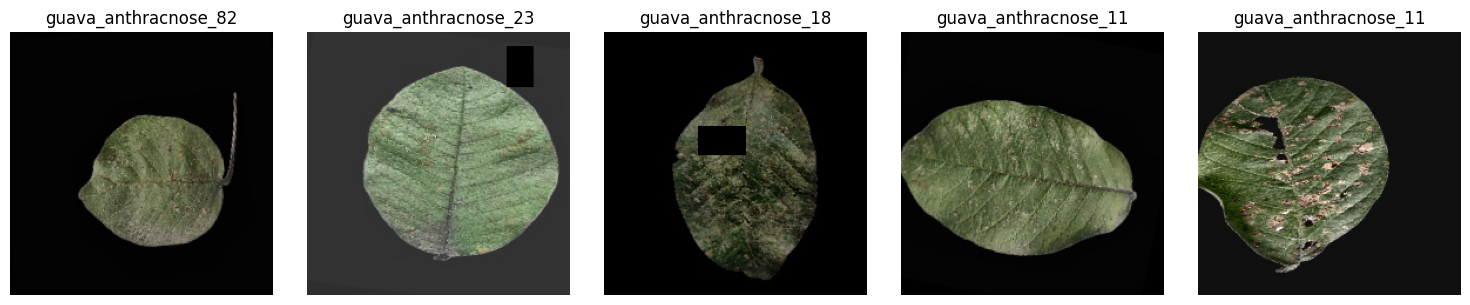

In [5]:
# Quick visual check
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Load a few augmented images
train_dir = Path("/Users/alimran/Desktop/Backend/Backend/Dataset_split/train/Guava_Anthracnose")
images = list(train_dir.glob("*_aug_*.jpg"))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_path.stem[:20])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Verify: All rotated images should have BLACK corners, not white

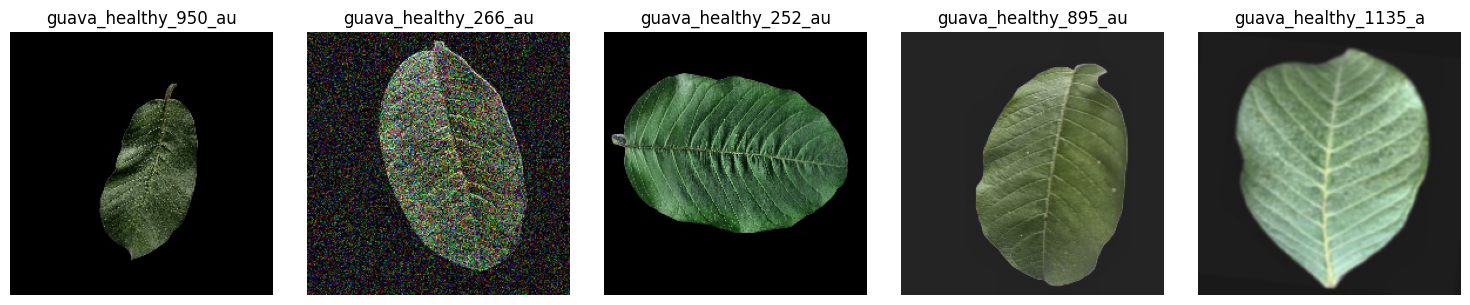

In [6]:


# Load a few augmented images
train_dir = Path("/Users/alimran/Desktop/Backend/Backend/Dataset_split/train/Guava_Healthy")
images = list(train_dir.glob("*_aug_*.jpg"))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_path.stem[:20])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Verify: All rotated images should have BLACK corners, not white

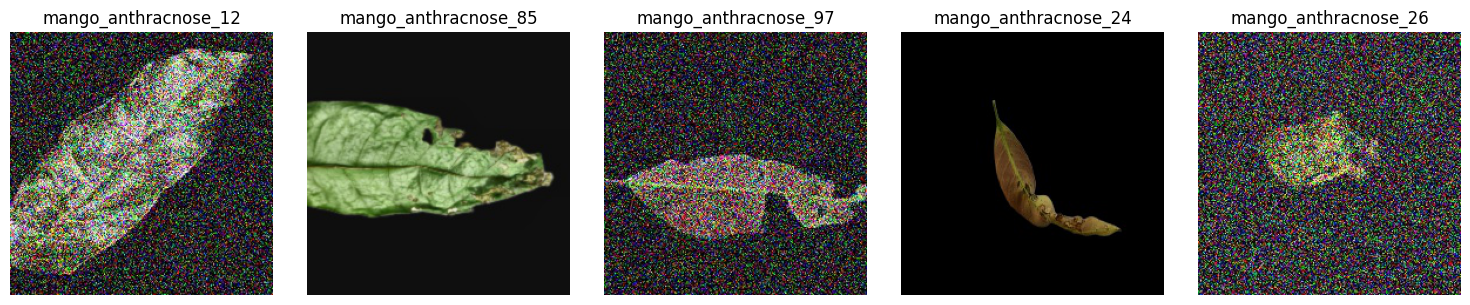

In [7]:


# Load a few augmented images
train_dir = Path("/Users/alimran/Desktop/Backend/Backend/Dataset_split/train/Mango_Anthracnose")
images = list(train_dir.glob("*_aug_*.jpg"))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_path.stem[:20])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Verify: All rotated images should have BLACK corners, not white

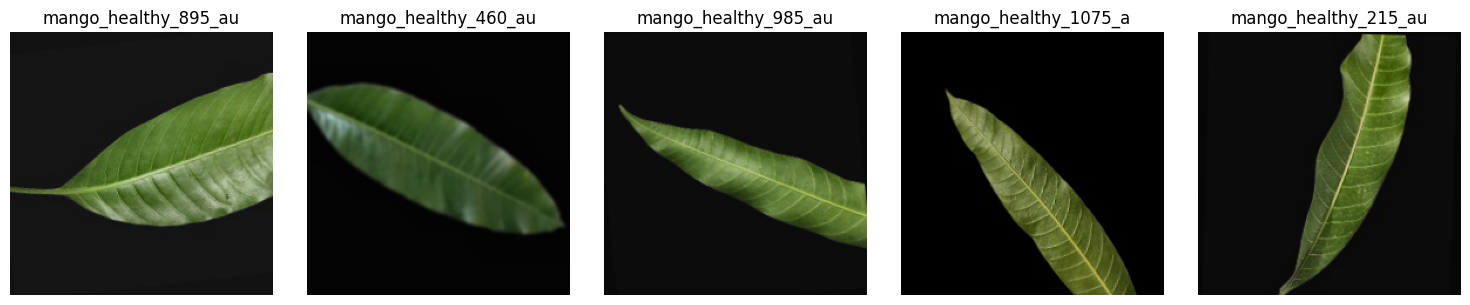

In [8]:

# Load a few augmented images
train_dir = Path("/Users/alimran/Desktop/Backend/Backend/Dataset_split/train/Mango_Healthy")
images = list(train_dir.glob("*_aug_*.jpg"))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_path.stem[:20])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Verify: All rotated images should have BLACK corners, not white

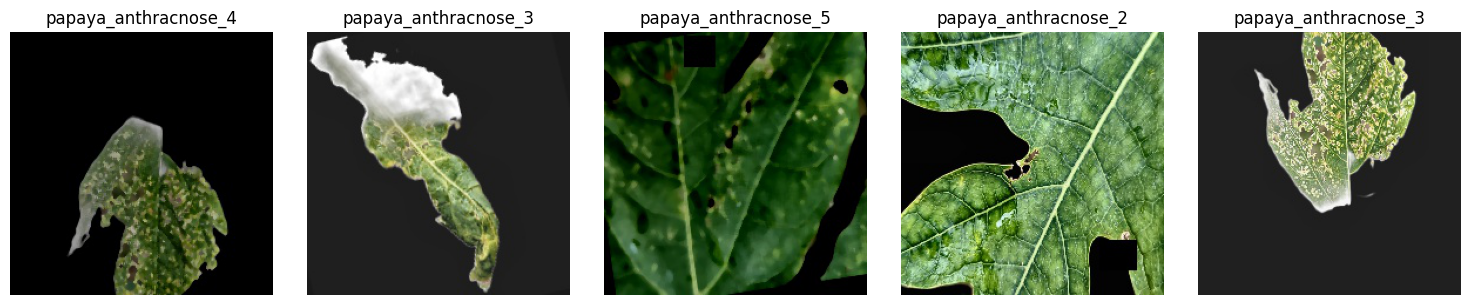

In [9]:


# Load a few augmented images
train_dir = Path("/Users/alimran/Desktop/Backend/Backend/Dataset_split/train/Papaya_Anthracnose")
images = list(train_dir.glob("*_aug_*.jpg"))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_path.stem[:20])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Verify: All rotated images should have BLACK corners, not white

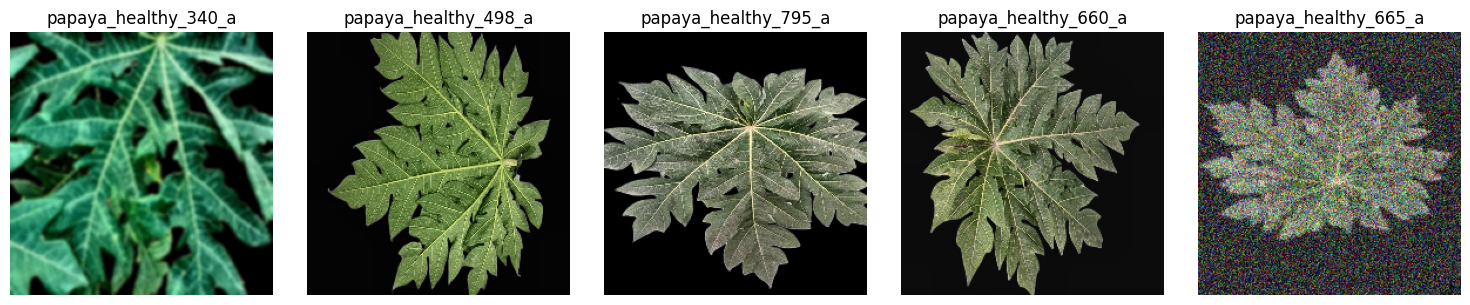

In [10]:


# Load a few augmented images
train_dir = Path("/Users/alimran/Desktop/Backend/Backend/Dataset_split/train/Papaya_Healthy")
images = list(train_dir.glob("*_aug_*.jpg"))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, img_path in zip(axes, images):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(img_path.stem[:20])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Verify: All rotated images should have BLACK corners, not white

# 📊 Dataset Visualizations

This section provides comprehensive visualizations of your dataset distribution, including:
1. Raw dataset class distribution
2. Train/Val/Test split distribution
3. Before vs After augmentation comparison
4. Duplicate distribution analysis
5. Augmentation strategy overview

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Visualization libraries loaded")
print("="*60)

✓ Visualization libraries loaded



📊 VISUALIZATION 1: Raw Dataset Class Distribution


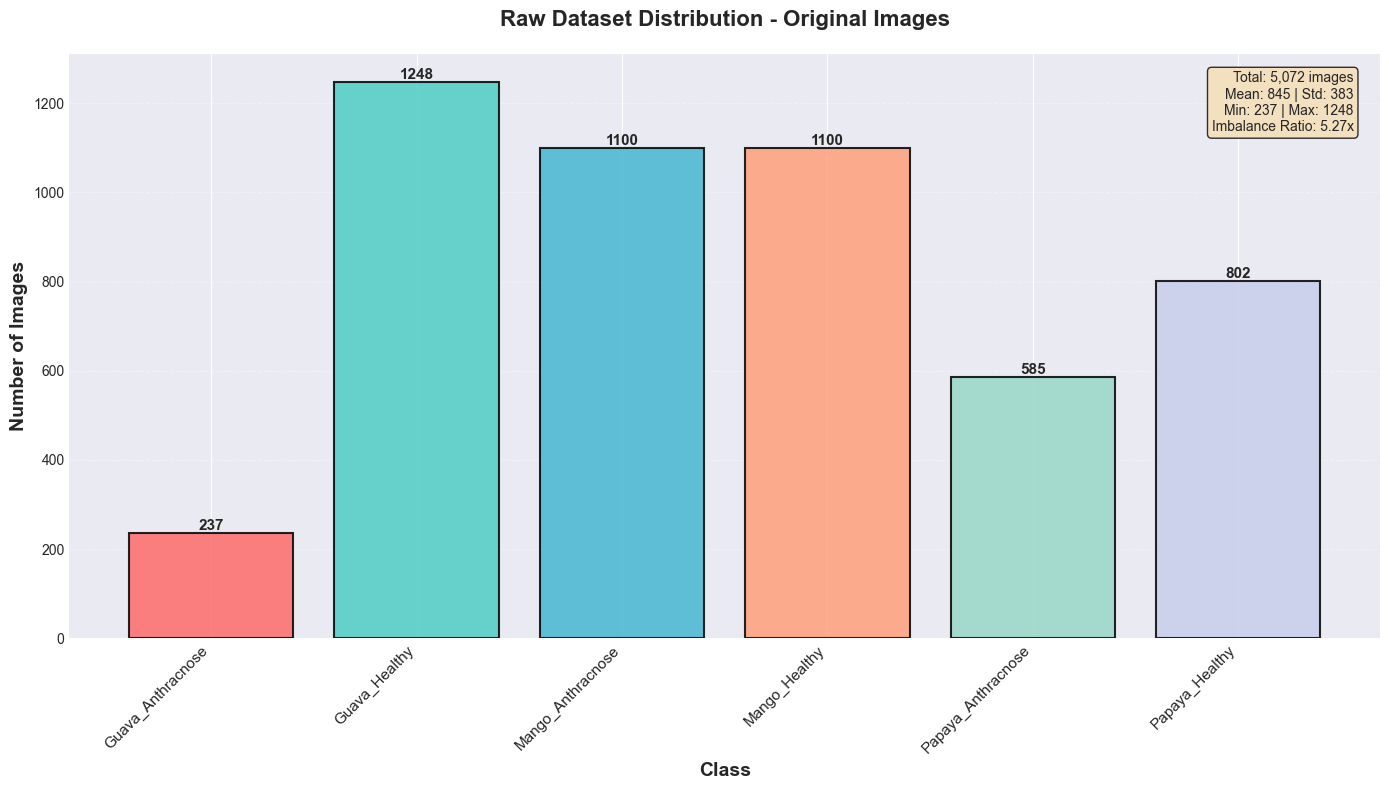

✓ Total raw images: 5,072
✓ Class imbalance ratio: 5.27x (max/min)


In [12]:
# ========================================
# 1. RAW DATASET DISTRIBUTION
# ========================================

print("\n📊 VISUALIZATION 1: Raw Dataset Class Distribution")
print("="*60)

# Get class counts from original dataframe
raw_counts = df["joint_label"].value_counts().sort_index()

# Create figure with better styling
fig, ax = plt.subplots(figsize=(14, 8))

# Create bar plot
bars = ax.bar(range(len(raw_counts)), raw_counts.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#C7CEEA'],
               edgecolor='black', linewidth=1.5, alpha=0.85)

# Customize plot
ax.set_xlabel('Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=14, fontweight='bold')
ax.set_title('Raw Dataset Distribution - Original Images', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(len(raw_counts)))
ax.set_xticklabels(raw_counts.index, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, raw_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(value)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add statistics
total = raw_counts.sum()
mean = raw_counts.mean()
std = raw_counts.std()
min_val = raw_counts.min()
max_val = raw_counts.max()
imbalance_ratio = max_val / min_val

stats_text = f'Total: {total:,} images\nMean: {mean:.0f} | Std: {std:.0f}\nMin: {min_val} | Max: {max_val}\nImbalance Ratio: {imbalance_ratio:.2f}x'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Total raw images: {total:,}")
print(f"✓ Class imbalance ratio: {imbalance_ratio:.2f}x (max/min)")
print("="*60)


📊 VISUALIZATION 2: Train/Val/Test Split Distribution (Original Images)


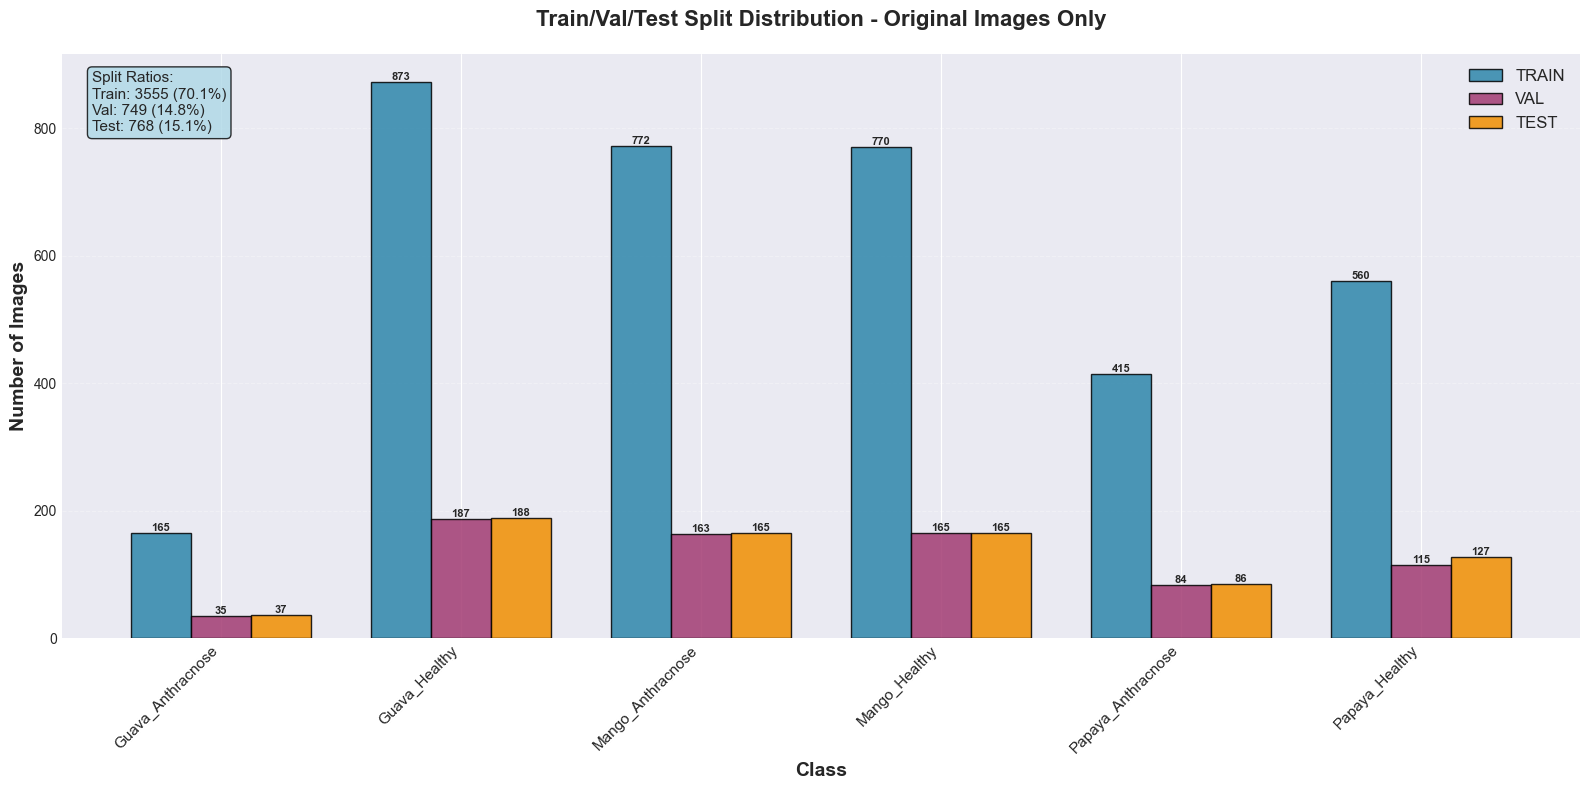

✓ Train: 3555 images (70.1%)
✓ Val:   749 images (14.8%)
✓ Test:  768 images (15.1%)


In [13]:
# ========================================
# 2. TRAIN/VAL/TEST SPLIT DISTRIBUTION
# ========================================

print("\n📊 VISUALIZATION 2: Train/Val/Test Split Distribution (Original Images)")
print("="*60)

# Prepare data for splits
split_data = []
for split in ['train', 'val', 'test']:
    split_df = df_split[df_split['split'] == split]
    for cls in sorted(df_split['joint_label'].unique()):
        count = len(split_df[split_df['joint_label'] == cls])
        split_data.append({
            'Split': split.upper(),
            'Class': cls,
            'Count': count
        })

split_df_plot = pd.DataFrame(split_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(16, 8))

classes = sorted(df_split['joint_label'].unique())
splits = ['TRAIN', 'VAL', 'TEST']
x = np.arange(len(classes))
width = 0.25

colors = {'TRAIN': '#2E86AB', 'VAL': '#A23B72', 'TEST': '#F18F01'}

for i, split in enumerate(splits):
    data = split_df_plot[split_df_plot['Split'] == split]
    counts = [data[data['Class'] == cls]['Count'].values[0] for cls in classes]
    bars = ax.bar(x + i*width, counts, width, label=split, 
                   color=colors[split], edgecolor='black', linewidth=1, alpha=0.85)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xlabel('Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=14, fontweight='bold')
ax.set_title('Train/Val/Test Split Distribution - Original Images Only', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add split ratios
train_total = split_df_plot[split_df_plot['Split'] == 'TRAIN']['Count'].sum()
val_total = split_df_plot[split_df_plot['Split'] == 'VAL']['Count'].sum()
test_total = split_df_plot[split_df_plot['Split'] == 'TEST']['Count'].sum()
total = train_total + val_total + test_total

ratios_text = f'Split Ratios:\nTrain: {train_total} ({train_total/total*100:.1f}%)\nVal: {val_total} ({val_total/total*100:.1f}%)\nTest: {test_total} ({test_total/total*100:.1f}%)'
ax.text(0.02, 0.97, ratios_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Train: {train_total} images ({train_total/total*100:.1f}%)")
print(f"✓ Val:   {val_total} images ({val_total/total*100:.1f}%)")
print(f"✓ Test:  {test_total} images ({test_total/total*100:.1f}%)")
print("="*60)


📊 VISUALIZATION 3: Train/Val/Test Ratio Pie Chart
✓ After augmentation:
  Train: 6,000 images (79.8%)
  Val:   749 images (10.0%)
  Test:  768 images (10.2%)


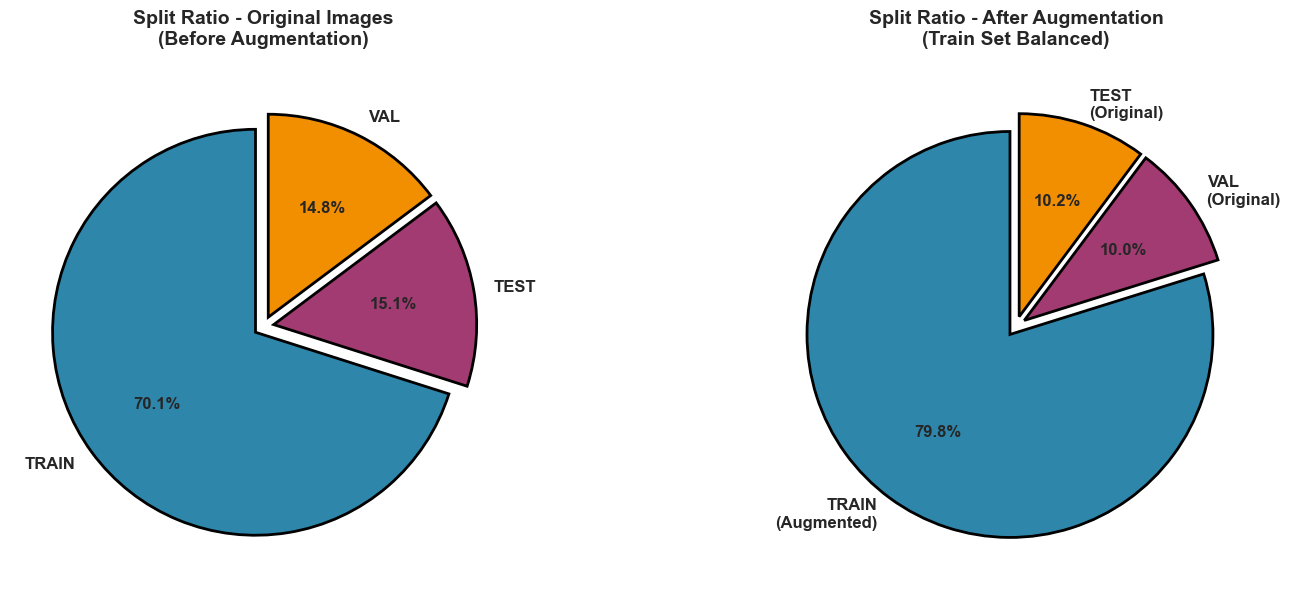

In [14]:
# ========================================
# 3. PIE CHART - SPLIT RATIO VISUALIZATION
# ========================================

print("\n📊 VISUALIZATION 3: Train/Val/Test Ratio Pie Chart")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart 1: Original images split ratio
split_counts = df_split['split'].value_counts()
colors_pie = ['#2E86AB', '#A23B72', '#F18F01']
explode = (0.05, 0.05, 0.05)

ax1.pie(split_counts.values, labels=[s.upper() for s in split_counts.index], 
        autopct='%1.1f%%', startangle=90, colors=colors_pie, explode=explode,
        textprops={'fontsize': 12, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax1.set_title('Split Ratio - Original Images\n(Before Augmentation)', 
              fontsize=14, fontweight='bold', pad=20)

# Pie chart 2: After augmentation (train set balanced)
# Count images in Dataset_split folder
train_count = 0
val_count = 0
test_count = 0

out_root = Path("Dataset_split")
if out_root.exists():
    for split in ['train', 'val', 'test']:
        split_path = out_root / split
        if split_path.exists():
            count = sum(1 for p in split_path.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"})
            if split == 'train':
                train_count = count
            elif split == 'val':
                val_count = count
            else:
                test_count = count

after_aug = [train_count, val_count, test_count]
after_aug_labels = ['TRAIN\n(Augmented)', 'VAL\n(Original)', 'TEST\n(Original)']

if sum(after_aug) > 0:
    ax2.pie(after_aug, labels=after_aug_labels, 
            autopct='%1.1f%%', startangle=90, colors=colors_pie, explode=explode,
            textprops={'fontsize': 12, 'fontweight': 'bold'},
            wedgeprops={'edgecolor': 'black', 'linewidth': 2})
    ax2.set_title('Split Ratio - After Augmentation\n(Train Set Balanced)', 
                  fontsize=14, fontweight='bold', pad=20)
    
    total_after = sum(after_aug)
    print(f"✓ After augmentation:")
    print(f"  Train: {train_count:,} images ({train_count/total_after*100:.1f}%)")
    print(f"  Val:   {val_count:,} images ({val_count/total_after*100:.1f}%)")
    print(f"  Test:  {test_count:,} images ({test_count/total_after*100:.1f}%)")
else:
    ax2.text(0.5, 0.5, 'Augmentation not yet complete', 
             ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()
print("="*60)


📊 VISUALIZATION 4: Before vs After Augmentation - Training Set


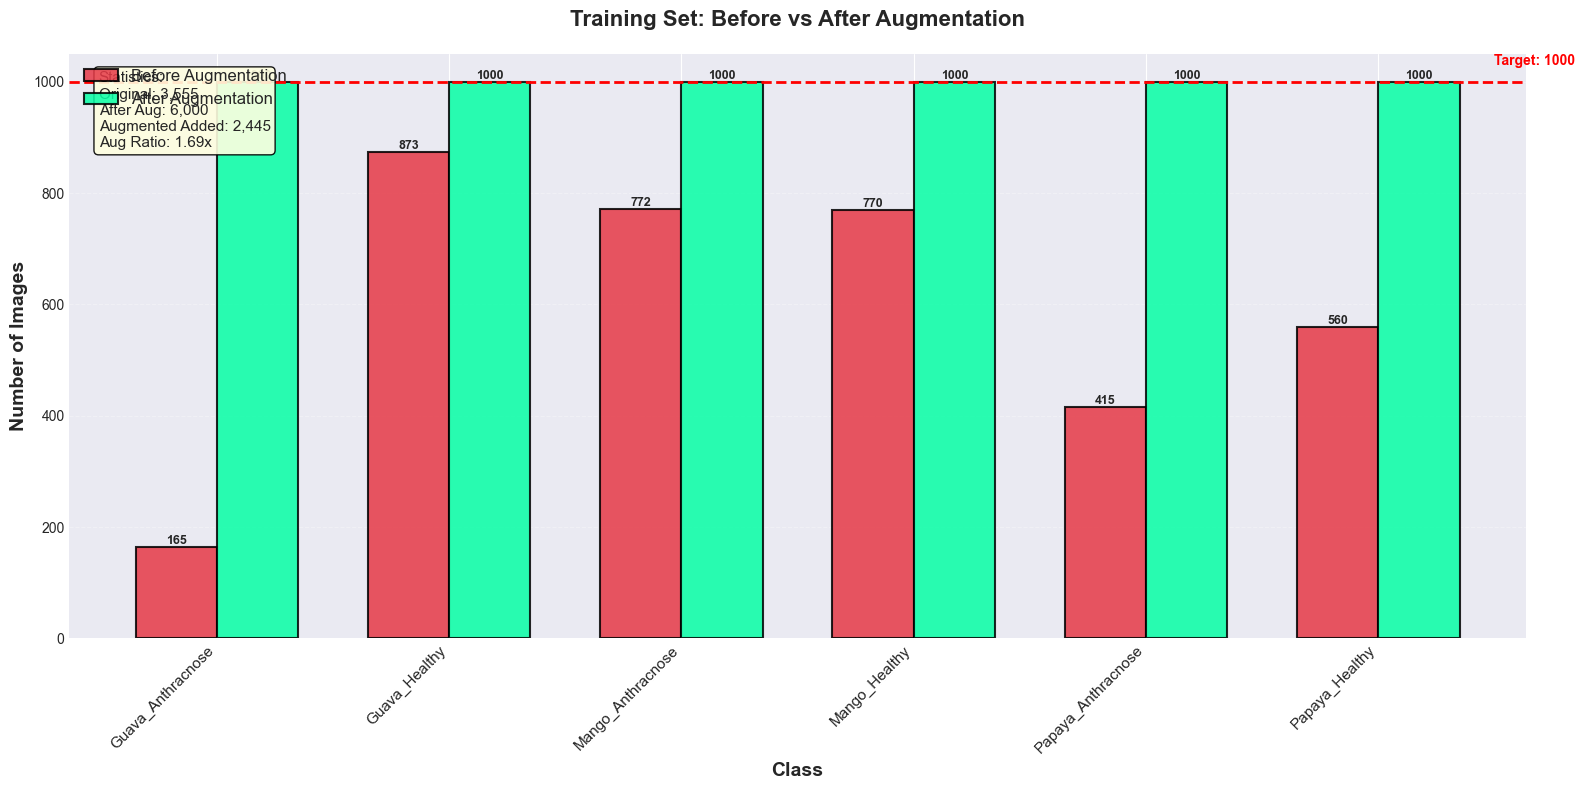

✓ Original training images: 3,555
✓ After augmentation: 6,000
✓ Augmented images added: 2,445
✓ Augmentation ratio: 1.69x


In [15]:
# ========================================
# 4. BEFORE vs AFTER AUGMENTATION COMPARISON
# ========================================

print("\n📊 VISUALIZATION 4: Before vs After Augmentation - Training Set")
print("="*60)

# Get before augmentation counts (original train set)
train_original = df_split[df_split['split'] == 'train']
before_counts = train_original['joint_label'].value_counts().sort_index()

# Get after augmentation counts from Dataset_split folder
after_counts = {}
out_root = Path("Dataset_split")
if (out_root / "train").exists():
    for cls in sorted(before_counts.index):
        cls_path = out_root / "train" / cls
        if cls_path.exists():
            count = sum(1 for p in cls_path.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"})
            after_counts[cls] = count
else:
    after_counts = {cls: 0 for cls in before_counts.index}

# Create comparison chart
fig, ax = plt.subplots(figsize=(16, 8))

classes = sorted(before_counts.index)
x = np.arange(len(classes))
width = 0.35

before_values = [before_counts[cls] for cls in classes]
after_values = [after_counts[cls] for cls in classes]

bars1 = ax.bar(x - width/2, before_values, width, label='Before Augmentation',
               color='#E63946', edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x + width/2, after_values, width, label='After Augmentation',
               color='#06FFA5', edgecolor='black', linewidth=1.5, alpha=0.85)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=14, fontweight='bold')
ax.set_title('Training Set: Before vs After Augmentation', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal line for target
if sum(after_values) > 0:
    target = TRAIN_TARGET_PER_CLASS
    ax.axhline(y=target, color='red', linestyle='--', linewidth=2, label=f'Target: {target}')
    ax.text(len(classes)-0.5, target+30, f'Target: {target}', 
            fontsize=10, color='red', fontweight='bold')

# Add augmentation statistics
total_before = sum(before_values)
total_after = sum(after_values)
augmented_added = total_after - total_before

stats_text = f'Statistics:\nOriginal: {total_before:,}\nAfter Aug: {total_after:,}\nAugmented Added: {augmented_added:,}\nAug Ratio: {total_after/total_before:.2f}x'
ax.text(0.02, 0.97, stats_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

print(f"✓ Original training images: {total_before:,}")
print(f"✓ After augmentation: {total_after:,}")
print(f"✓ Augmented images added: {augmented_added:,}")
print(f"✓ Augmentation ratio: {total_after/total_before:.2f}x")
print("="*60)


📊 VISUALIZATION 5: Duplicate Distribution Across Splits


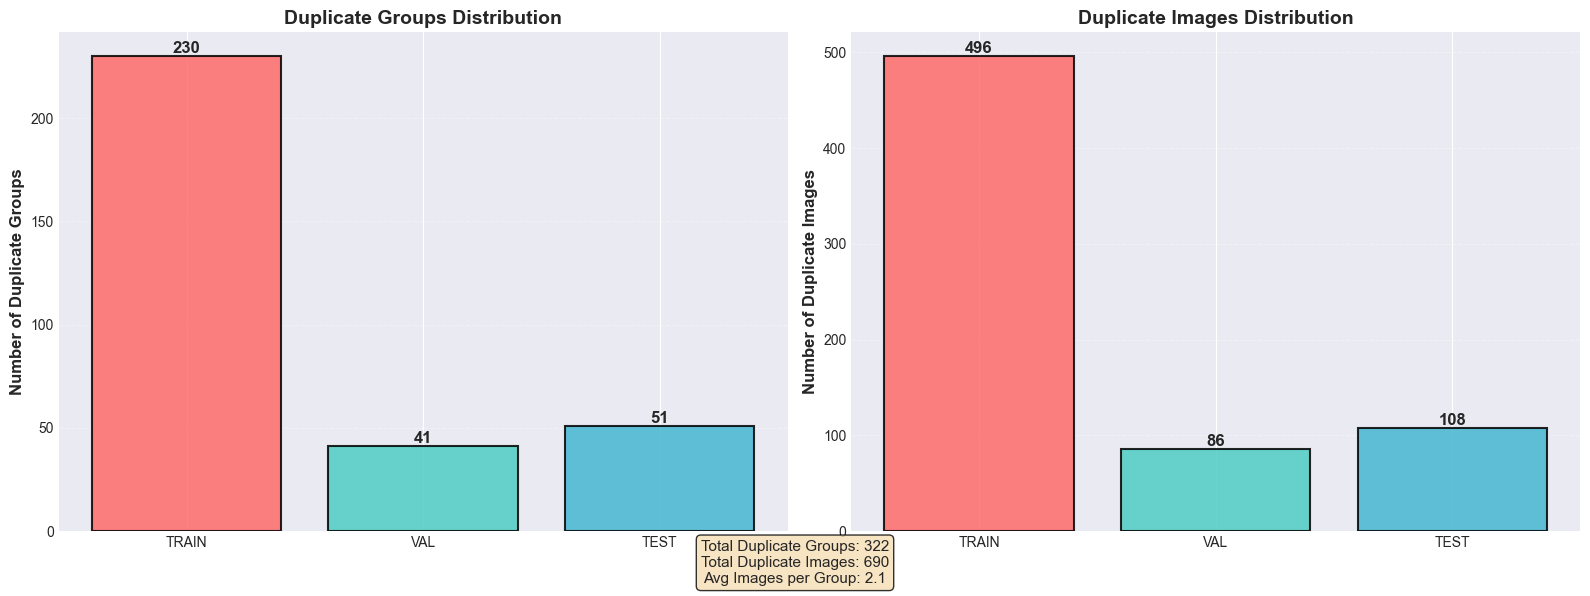

✓ Total duplicate groups: 322
✓ Total duplicate images: 690
✓ Distribution (groups): Train=230, Val=41, Test=51
✓ Distribution (images): Train=496, Val=86, Test=108


In [16]:
# ========================================
# 5. DUPLICATE DISTRIBUTION VISUALIZATION
# ========================================

print("\n📊 VISUALIZATION 5: Duplicate Distribution Across Splits")
print("="*60)

# Find duplicate groups
dup_groups = df_split.groupby("group_id").size()
duplicates = dup_groups[dup_groups > 1]

if len(duplicates) > 0:
    # Count duplicates per split
    dup_data = []
    for split in ['train', 'val', 'test']:
        split_df = df_split[df_split['split'] == split]
        split_dup_groups = split_df[split_df['group_id'].isin(duplicates.index)]
        
        unique_groups = split_dup_groups['group_id'].nunique()
        total_images = len(split_dup_groups)
        
        dup_data.append({
            'Split': split.upper(),
            'Groups': unique_groups,
            'Images': total_images
        })
    
    dup_df = pd.DataFrame(dup_data)
    
    # Create dual bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Chart 1: Duplicate groups per split
    bars1 = ax1.bar(dup_df['Split'], dup_df['Groups'], 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                    edgecolor='black', linewidth=1.5, alpha=0.85)
    ax1.set_ylabel('Number of Duplicate Groups', fontsize=12, fontweight='bold')
    ax1.set_title('Duplicate Groups Distribution', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Chart 2: Duplicate images per split
    bars2 = ax2.bar(dup_df['Split'], dup_df['Images'],
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                    edgecolor='black', linewidth=1.5, alpha=0.85)
    ax2.set_ylabel('Number of Duplicate Images', fontsize=12, fontweight='bold')
    ax2.set_title('Duplicate Images Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add statistics
    total_dup_groups = len(duplicates)
    total_dup_images = duplicates.sum()
    
    stats_text = f'Total Duplicate Groups: {total_dup_groups}\nTotal Duplicate Images: {total_dup_images}\nAvg Images per Group: {total_dup_images/total_dup_groups:.1f}'
    fig.text(0.5, 0.02, stats_text, ha='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()
    
    print(f"✓ Total duplicate groups: {total_dup_groups}")
    print(f"✓ Total duplicate images: {total_dup_images}")
    print(f"✓ Distribution (groups): Train={dup_df.iloc[0]['Groups']}, Val={dup_df.iloc[1]['Groups']}, Test={dup_df.iloc[2]['Groups']}")
    print(f"✓ Distribution (images): Train={dup_df.iloc[0]['Images']}, Val={dup_df.iloc[1]['Images']}, Test={dup_df.iloc[2]['Images']}")
else:
    print("✓ No duplicate groups found in dataset")
    
print("="*60)


📊 VISUALIZATION 6: Adaptive Augmentation Strategy per Class


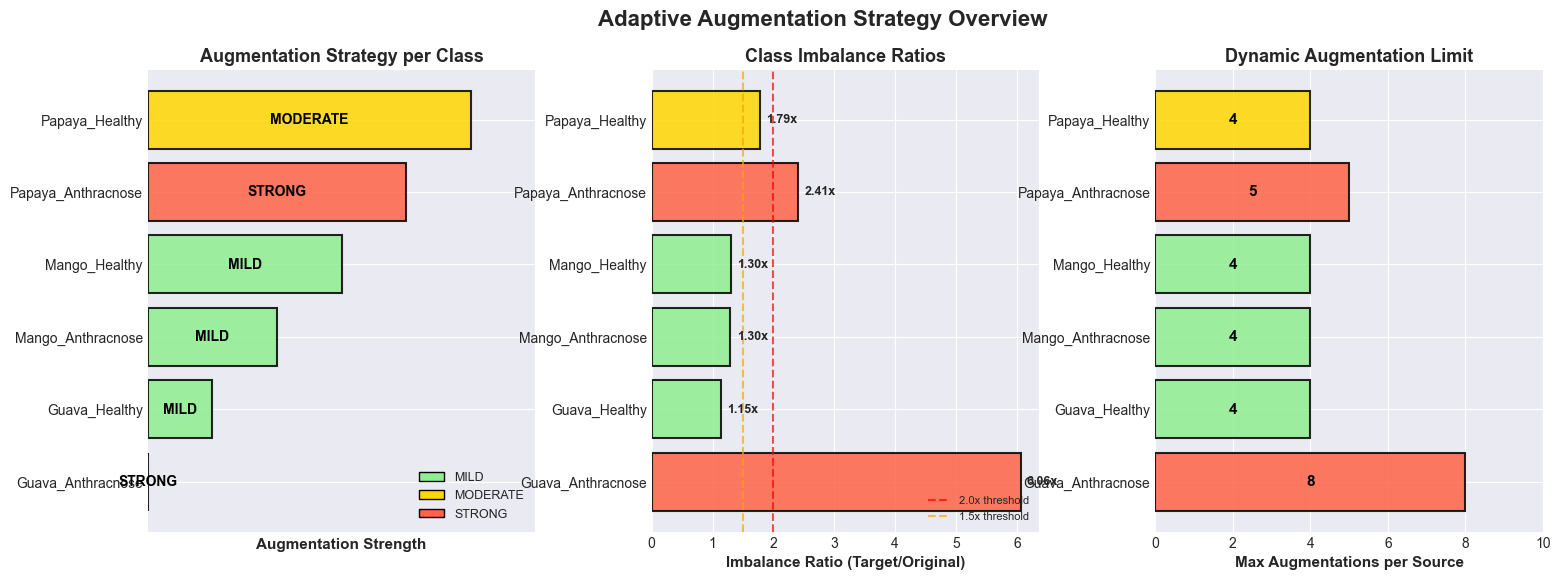

✓ Strategy Summary:
  Guava_Anthracnose        : STRONG   | Ratio=6.06x | MaxAug=8
  Guava_Healthy            : MILD     | Ratio=1.15x | MaxAug=4
  Mango_Anthracnose        : MILD     | Ratio=1.30x | MaxAug=4
  Mango_Healthy            : MILD     | Ratio=1.30x | MaxAug=4
  Papaya_Anthracnose       : STRONG   | Ratio=2.41x | MaxAug=5
  Papaya_Healthy           : MODERATE | Ratio=1.79x | MaxAug=4


In [17]:
# ========================================
# 6. AUGMENTATION STRATEGY VISUALIZATION
# ========================================

print("\n📊 VISUALIZATION 6: Adaptive Augmentation Strategy per Class")
print("="*60)

# Prepare augmentation strategy data
aug_strategy_data = []
for cls, config in class_aug_configs.items():
    aug_strategy_data.append({
        'Class': cls,
        'Strategy': config['strength'],
        'Imbalance Ratio': config['imbalance_ratio'],
        'Max Aug per Source': config['max_aug']
    })

aug_df = pd.DataFrame(aug_strategy_data)

# Create figure with 3 subplots
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Chart 1: Augmentation strategy
strategy_colors = {'MILD': '#90EE90', 'MODERATE': '#FFD700', 'STRONG': '#FF6347'}
colors = [strategy_colors[s] for s in aug_df['Strategy']]

bars1 = ax1.barh(aug_df['Class'], range(len(aug_df)), color=colors,
                 edgecolor='black', linewidth=1.5, alpha=0.85)
ax1.set_xlabel('Augmentation Strength', fontsize=11, fontweight='bold')
ax1.set_title('Augmentation Strategy per Class', fontsize=13, fontweight='bold')
ax1.set_xlim(0, len(aug_df))
ax1.set_xticks([])

# Add strategy labels on bars
for i, (bar, strategy) in enumerate(zip(bars1, aug_df['Strategy'])):
    width = bar.get_width()
    ax1.text(width/2, bar.get_y() + bar.get_height()/2,
            strategy, ha='center', va='center', 
            fontsize=10, fontweight='bold', color='black')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=strategy_colors[s], edgecolor='black', label=s) 
                   for s in ['MILD', 'MODERATE', 'STRONG']]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Chart 2: Imbalance ratio
bars2 = ax2.barh(aug_df['Class'], aug_df['Imbalance Ratio'],
                 color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)
ax2.set_xlabel('Imbalance Ratio (Target/Original)', fontsize=11, fontweight='bold')
ax2.set_title('Class Imbalance Ratios', fontsize=13, fontweight='bold')
ax2.axvline(x=2.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='2.0x threshold')
ax2.axvline(x=1.5, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='1.5x threshold')
ax2.legend(fontsize=8, loc='lower right')

for bar, ratio in zip(bars2, aug_df['Imbalance Ratio']):
    width = bar.get_width()
    ax2.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            f'{ratio:.2f}x', va='center', fontsize=9, fontweight='bold')

# Chart 3: Max augmentations per source
bars3 = ax3.barh(aug_df['Class'], aug_df['Max Aug per Source'],
                 color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)
ax3.set_xlabel('Max Augmentations per Source', fontsize=11, fontweight='bold')
ax3.set_title('Dynamic Augmentation Limit', fontsize=13, fontweight='bold')
ax3.set_xlim(0, 10)

for bar, max_aug in zip(bars3, aug_df['Max Aug per Source']):
    width = bar.get_width()
    ax3.text(width/2, bar.get_y() + bar.get_height()/2,
            f'{int(max_aug)}', ha='center', va='center',
            fontsize=11, fontweight='bold', color='black')

plt.suptitle('Adaptive Augmentation Strategy Overview', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ Strategy Summary:")
for _, row in aug_df.iterrows():
    print(f"  {row['Class']:25s}: {row['Strategy']:8s} | Ratio={row['Imbalance Ratio']:.2f}x | MaxAug={row['Max Aug per Source']}")
print("="*60)


📊 VISUALIZATION 7: Complete Dataset Overview


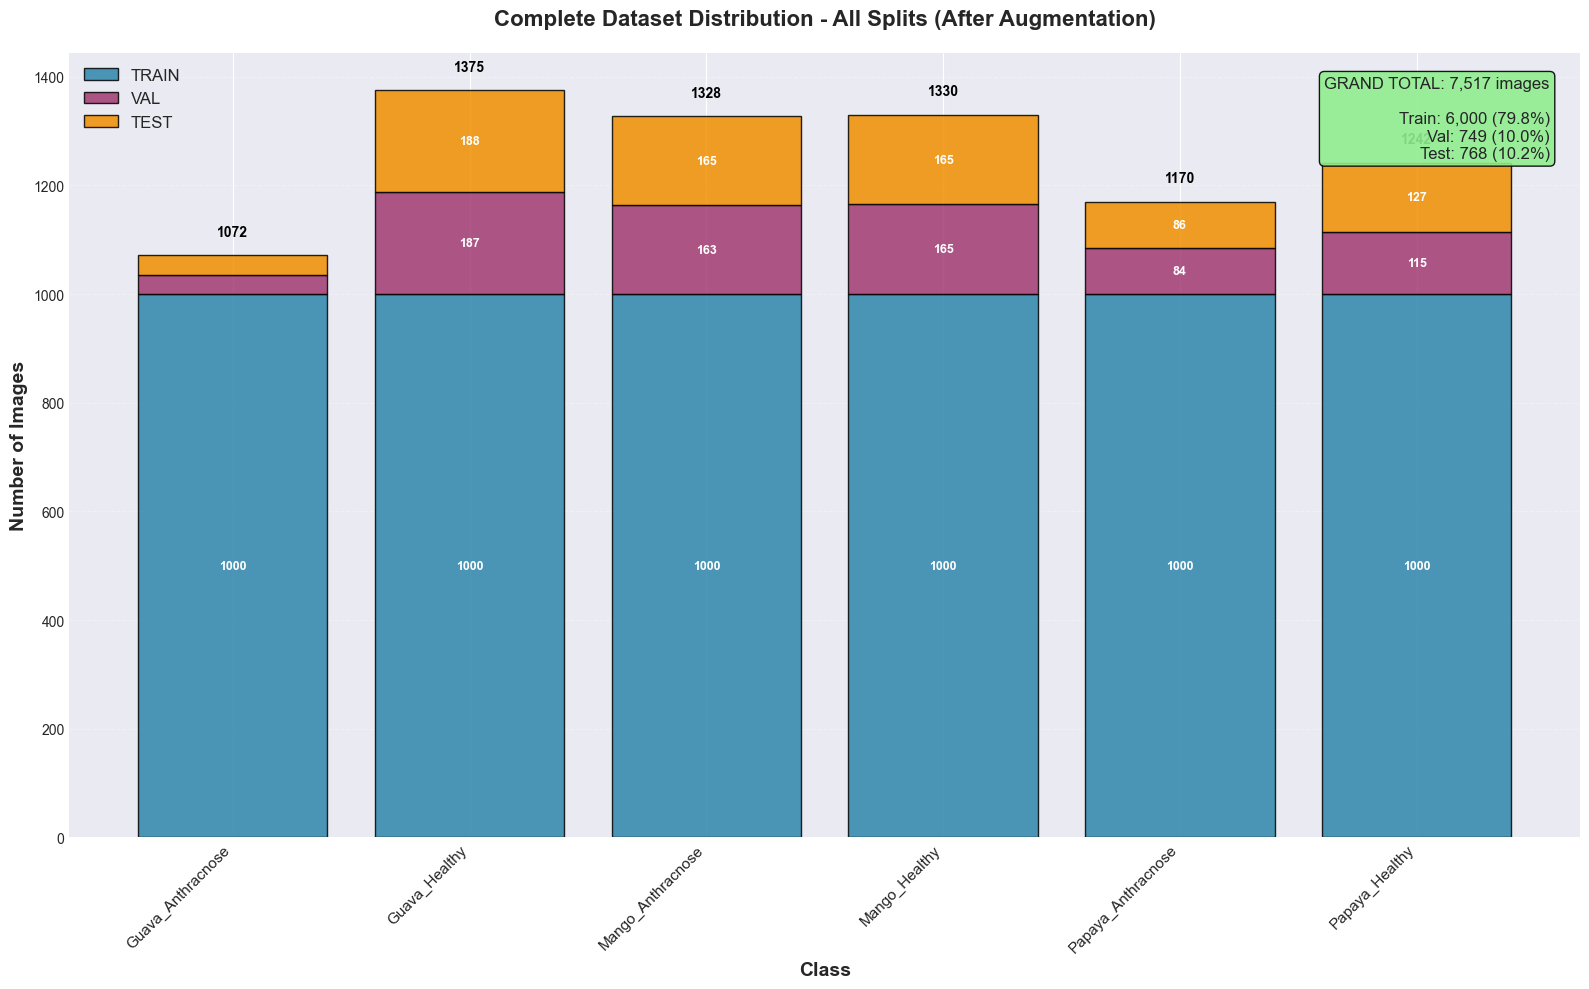

✓ Grand Total: 7,517 images
  Train: 6,000 (79.8%)
  Val:   749 (10.0%)
  Test:  768 (10.2%)


In [18]:
# ========================================
# 7. COMPREHENSIVE DATASET OVERVIEW
# ========================================

print("\n📊 VISUALIZATION 7: Complete Dataset Overview")
print("="*60)

# Collect all data
final_counts = {}
out_root = Path("Dataset_split")

for split in ['train', 'val', 'test']:
    final_counts[split] = {}
    split_path = out_root / split
    if split_path.exists():
        for cls in sorted(df_split['joint_label'].unique()):
            cls_path = split_path / cls
            if cls_path.exists():
                count = sum(1 for p in cls_path.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"})
                final_counts[split][cls] = count
            else:
                final_counts[split][cls] = 0

# Create comprehensive stacked bar chart
fig, ax = plt.subplots(figsize=(16, 10))

classes = sorted(df_split['joint_label'].unique())
splits = ['train', 'val', 'test']
colors_split = {'train': '#2E86AB', 'val': '#A23B72', 'test': '#F18F01'}

# Prepare data
data_matrix = []
for split in splits:
    data_matrix.append([final_counts[split].get(cls, 0) for cls in classes])

# Create stacked bars
x = np.arange(len(classes))
bottom = np.zeros(len(classes))

for i, split in enumerate(splits):
    bars = ax.bar(x, data_matrix[i], bottom=bottom, label=split.upper(),
                   color=colors_split[split], edgecolor='black', linewidth=1, alpha=0.85)
    
    # Add value labels
    for j, (bar, value) in enumerate(zip(bars, data_matrix[i])):
        if value > 50:  # Only show labels for significant values
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., bottom[j] + height/2,
                    f'{int(value)}',
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    bottom += data_matrix[i]

# Add total on top
for i, total in enumerate(bottom):
    ax.text(i, total + 30, f'{int(total)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

ax.set_xlabel('Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=14, fontweight='bold')
ax.set_title('Complete Dataset Distribution - All Splits (After Augmentation)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add grand totals
grand_total = sum(bottom)
train_total = sum(data_matrix[0])
val_total = sum(data_matrix[1])
test_total = sum(data_matrix[2])

totals_text = f'GRAND TOTAL: {int(grand_total):,} images\n\nTrain: {int(train_total):,} ({train_total/grand_total*100:.1f}%)\nVal: {int(val_total):,} ({val_total/grand_total*100:.1f}%)\nTest: {int(test_total):,} ({test_total/grand_total*100:.1f}%)'
ax.text(0.98, 0.97, totals_text, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9))

plt.tight_layout()
plt.show()

print(f"✓ Grand Total: {int(grand_total):,} images")
print(f"  Train: {int(train_total):,} ({train_total/grand_total*100:.1f}%)")
print(f"  Val:   {int(val_total):,} ({val_total/grand_total*100:.1f}%)")
print(f"  Test:  {int(test_total):,} ({test_total/grand_total*100:.1f}%)")
print("="*60)


📊 VISUALIZATION 8: Class Distribution Heatmap


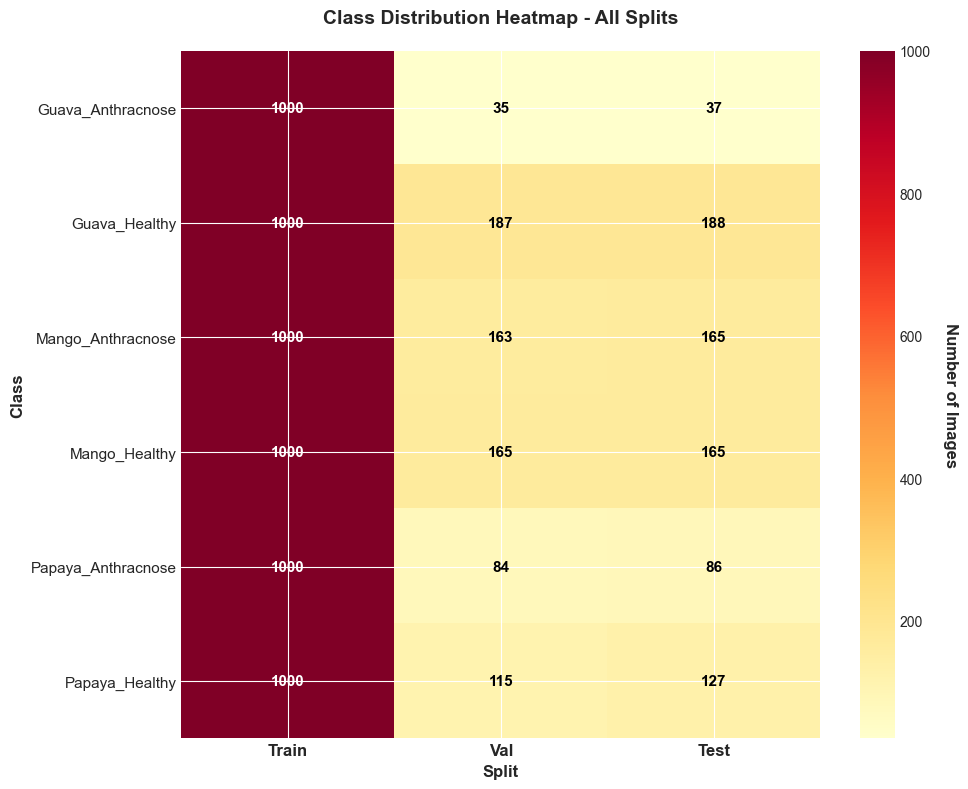

✓ Heatmap shows image count per class per split


In [19]:
# ========================================
# 8. HEATMAP - CLASS DISTRIBUTION MATRIX
# ========================================

print("\n📊 VISUALIZATION 8: Class Distribution Heatmap")
print("="*60)

# Create matrix for heatmap
heatmap_data = []
for cls in sorted(df_split['joint_label'].unique()):
    row = []
    for split in ['train', 'val', 'test']:
        count = final_counts[split].get(cls, 0)
        row.append(count)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, 
                          columns=['Train', 'Val', 'Test'],
                          index=sorted(df_split['joint_label'].unique()))

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(heatmap_df.values, cmap='YlOrRd', aspect='auto')

# Set ticks
ax.set_xticks(np.arange(len(heatmap_df.columns)))
ax.set_yticks(np.arange(len(heatmap_df.index)))
ax.set_xticklabels(heatmap_df.columns, fontsize=12, fontweight='bold')
ax.set_yticklabels(heatmap_df.index, fontsize=11)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of Images', rotation=270, labelpad=20, fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.columns)):
        value = heatmap_df.values[i, j]
        text = ax.text(j, i, f'{int(value)}',
                      ha="center", va="center", 
                      color="black" if value < heatmap_df.values.max()*0.6 else "white",
                      fontsize=11, fontweight='bold')

ax.set_title('Class Distribution Heatmap - All Splits', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Split', fontsize=12, fontweight='bold')
ax.set_ylabel('Class', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Heatmap shows image count per class per split")
print("="*60)


📊 VISUALIZATION 9: Dataset Summary Statistics


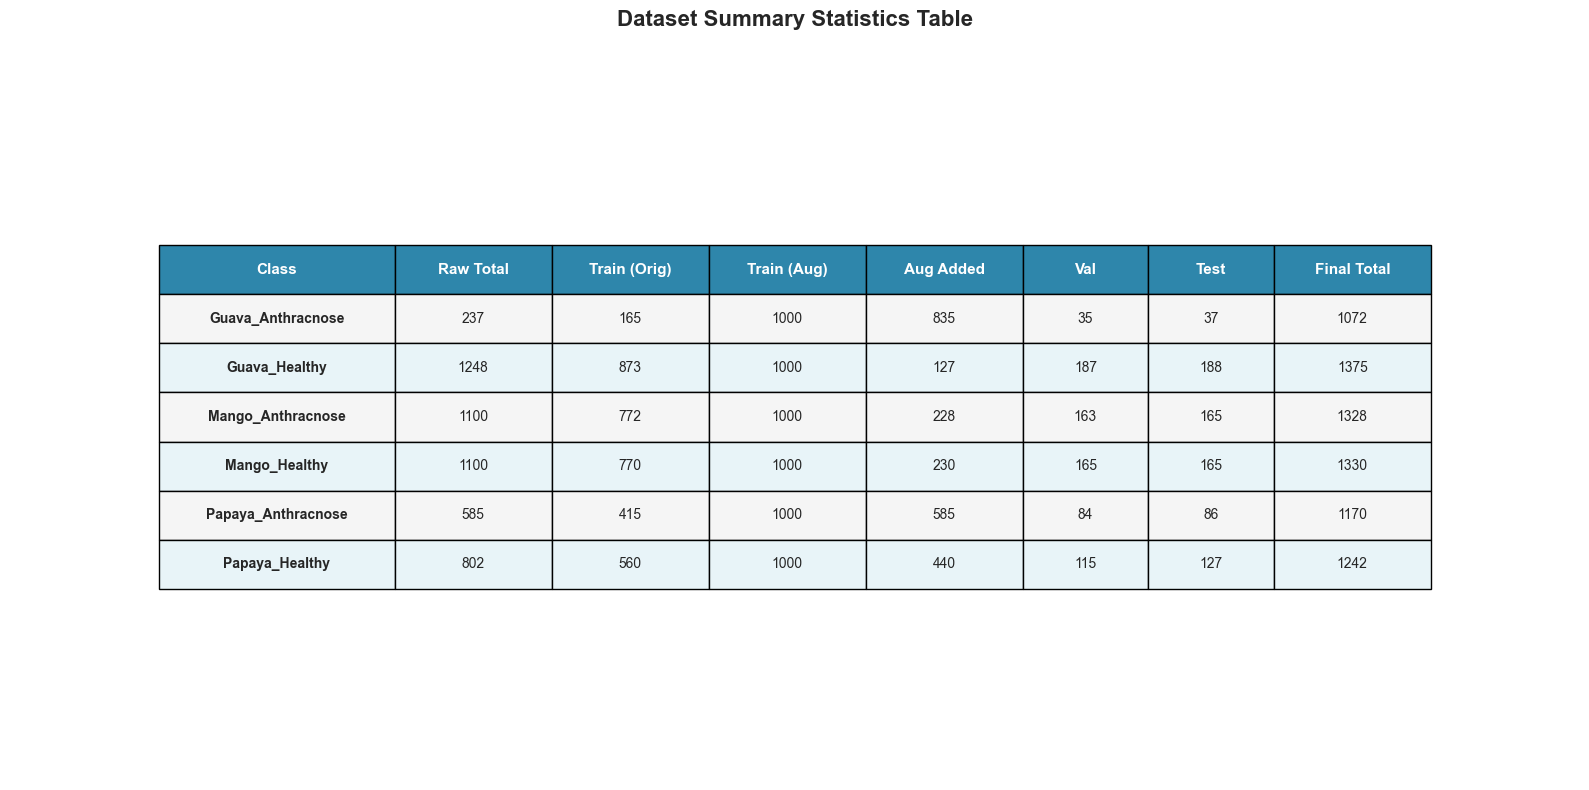


📈 DATASET SUMMARY:
Total Raw Images:        5,072
Total After Processing:  7,517
Total Augmented Added:   2,445

Per-Split Totals (After Aug):
  Train: 6,000
  Val:   749
  Test:  768


In [20]:
# ========================================
# 9. SUMMARY STATISTICS TABLE
# ========================================

print("\n📊 VISUALIZATION 9: Dataset Summary Statistics")
print("="*60)

# Create comprehensive summary table
summary_data = []

for cls in sorted(df_split['joint_label'].unique()):
    # Original counts
    original = len(df[df['joint_label'] == cls])
    
    # Split counts (original)
    train_orig = len(df_split[(df_split['joint_label'] == cls) & (df_split['split'] == 'train')])
    val_orig = len(df_split[(df_split['joint_label'] == cls) & (df_split['split'] == 'val')])
    test_orig = len(df_split[(df_split['joint_label'] == cls) & (df_split['split'] == 'test')])
    
    # After augmentation
    train_aug = final_counts['train'].get(cls, 0)
    val_aug = final_counts['val'].get(cls, 0)
    test_aug = final_counts['test'].get(cls, 0)
    
    # Augmented added
    aug_added = train_aug - train_orig
    
    summary_data.append({
        'Class': cls,
        'Raw Total': original,
        'Train (Orig)': train_orig,
        'Train (Aug)': train_aug,
        'Aug Added': aug_added,
        'Val': val_orig,
        'Test': test_orig,
        'Final Total': train_aug + val_aug + test_aug
    })

summary_df = pd.DataFrame(summary_data)

# Display as formatted table
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=summary_df.values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.15, 0.1, 0.1, 0.1, 0.1, 0.08, 0.08, 0.1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Color header
for i in range(len(summary_df.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#2E86AB')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Color cells
for i in range(1, len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E8F4F8')
        else:
            cell.set_facecolor('#F5F5F5')
        
        # Bold class name
        if j == 0:
            cell.set_text_props(weight='bold')

ax.set_title('Dataset Summary Statistics Table', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print summary
print("\n📈 DATASET SUMMARY:")
print("="*60)
print(f"Total Raw Images:        {summary_df['Raw Total'].sum():,}")
print(f"Total After Processing:  {summary_df['Final Total'].sum():,}")
print(f"Total Augmented Added:   {summary_df['Aug Added'].sum():,}")
print(f"\nPer-Split Totals (After Aug):")
print(f"  Train: {summary_df['Train (Aug)'].sum():,}")
print(f"  Val:   {summary_df['Val'].sum():,}")
print(f"  Test:  {summary_df['Test'].sum():,}")
print("="*60)